## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

## Load Dataset

In [2]:
data = pd.read_csv('/content/ab_data.csv')
data.head()

,user_id,timestamp,group,landing_page,converted
0,851104,11:48.6,control,old_page,0
1,804228,01:45.2,control,old_page,0
2,661590,55:06.2,treatment,new_page,0
3,853541,28:03.1,treatment,new_page,0
4,864975,52:26.2,control,old_page,1


## Get basic informations

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294480 entries, 0 to 294479
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294480 non-null  int64 
 1   timestamp     294480 non-null  object
 2   group         294480 non-null  object
 3   landing_page  294480 non-null  object
 4   converted     294480 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


In [4]:
data.shape

(294480, 5)

In [5]:
data.isnull().sum()

,0
user_id,0
timestamp,0
group,0
landing_page,0
converted,0


In [6]:
data.duplicated().sum()

0

## EDA and Visualizations

<ipython-input-7-7c848416e7b2>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data, x='group', palette='twilight')


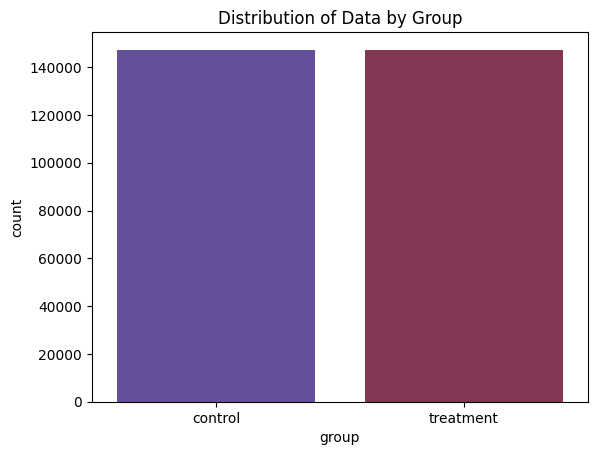

In [7]:
# Create a count plot to visualize the distribution of data by group
sns.countplot(data=data, x='group', palette='twilight')

# Add title to the plot
plt.title('Distribution of Data by Group')

# Display the plot
plt.show()

In [8]:
# Checkin alignment between group and landing_page
alignment_issues = data[(data['group'] == 'control') & (data['landing_page'] != 'old_page') |
                        (data['group'] == 'treatment') & (data['landing_page'] != 'new_page')]
print(f'\nNumber of misalignments between group and landing_page: {len(alignment_issues)}')


Number of misalignments between group and landing_page: 3893


The purpose of checking the group column is to verify whether the data in the group column (control and treatment) aligns correctly with the corresponding landing page.

In [9]:
# Removing misalignment between group and landing page
data_cleaned = data[
    ((data['group'] == 'control') & (data['landing_page'] == 'old_page')) |
    ((data['group'] == 'treatment') & (data['landing_page'] == 'new_page'))]

# Confirming the number of records before and after cleaning
print(f'Number of records before cleaning: {len(data)}')
print(f'Number of records after cleaning: {len(data_cleaned)}')
print(f'Number of records removed: {len(data) - len(data_cleaned)}')

Number of records before cleaning: 294480
Number of records after cleaning: 290587
Number of records removed: 3893


The data cleaning process successfully addressed the misalignment between the 'group' and 'landing_page' columns. Before cleaning, the dataset contained 294,480 records. After removing the misaligned records, the dataset now includes 290,587 records, resulting in the removal of 3,893 misaligned entries. This cleaning step ensures that the dataset is aligned correctly for subsequent analysis, providing more accurate and reliable results for the A/B testing.

In [10]:
data_cleaned['group'].value_counts()

,count
group,
treatment,145313
control,145274


In [20]:
# Conversion rate by group
conversion_rate = data_cleaned.groupby('group')['converted'].mean()
print('\nConversion rate per group:')
print(conversion_rate)


Conversion rate per group:
group
control      0.120386
treatment    0.118806
Name: converted, dtype: float64


Based on the conversion rate results above, it is evident that the difference between the control and treatment groups is minimal. This suggests that the new landing page (new_page) may not have had a significant impact on the conversion rate.

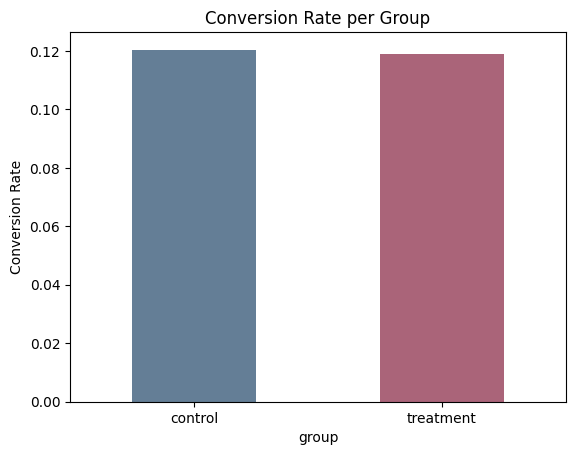

In [12]:
# Plot conversion rates by group as a bar chart
conversion_rate.plot(kind='bar', color=['#23486A', '#872341'], alpha=0.7)

# Add title and label for the y-axis
plt.title('Conversion Rate per Group')
plt.ylabel('Conversion Rate')
plt.xticks(rotation = 0)

# Display the plot
plt.show()

In [13]:
# Checkin overall conversion rate
overall_conversion_rate = data['converted'].mean()
print(f'\nOverall conversion rate: {overall_conversion_rate:.2%}')


Overall conversion rate: 11.97%


By examining the overall conversion rate, which is approximately 11.97% (the combined rate for both the control and treatment groups), it can be concluded that 11.97% of users successfully converted. This indicates that 11.97% of users took the desired action, such as making a purchase, registering, or performing any other activity intended as part of the conversion goal.

In [14]:
# Calculate basic statistics to understand the sample distribution
conversion_rates_by_group = data_cleaned.groupby('group')['converted']

# Define functions to calculate standard deviation and standard error
std_dev = lambda x: np.std(x, ddof=0)
std_error = lambda x: stats.sem(x, ddof=0)

# Aggregate statistics by group
conversion_rates_summary = conversion_rates_by_group.agg([np.mean, std_dev, std_error])

# Rename columns for clarity
conversion_rates_summary.columns = ['conversion_rate', 'std_deviation', 'std_error']

# Display the statistics with three decimal places
conversion_rates_summary.style.format('{:.3f}')

<ipython-input-14-d03e0d47b6dc>:9: FutureWarning: The provided callable <function mean at 0x7a24b7f90e00> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  conversion_rates_summary = conversion_rates_by_group.agg([np.mean, std_dev, std_error])


,conversion_rate,std_deviation,std_error
group,,,
control,0.120,0.325,0.001
treatment,0.119,0.324,0.001


The difference in conversion rates between the control and treatment groups is minimal, with only a 0.01 difference. This suggests that the observed difference is likely not statistically significant. Furthermore, examining the standard deviation and standard error, it can be concluded that the data distribution across both groups is similar, indicating that the sample adequately represents both groups.

## Comparing control and treatment groups in an A/B  test

In [16]:
# Conversion count and group size for each group
control_conversions = data_cleaned[data_cleaned['group'] == 'control']['converted'].sum()
treatment_conversions = data_cleaned[data_cleaned['group'] == 'treatment']['converted'].sum()

control_sample_size = data_cleaned[data_cleaned['group'] == 'control']['converted'].count()
treatment_sample_size = data_cleaned[data_cleaned['group'] == 'treatment']['converted'].count()

# Conversion values and sample sizes for both groups
conversion_counts = [control_conversions, treatment_conversions]
sample_sizes = [control_sample_size, treatment_sample_size]

# Calculate Z-statistics and p-value
z_statistic, p_value = proportions_ztest(conversion_counts, sample_sizes)

print(f"Z-Statistic: {z_statistic:.4f}")
print(f"P-Value: {p_value:.4f}")

Z-Statistic: 1.3130
P-Value: 0.1892


Based on the results, it can be observed that the difference in conversion rates between the control and treatment groups is relatively small, as indicated by the Z-statistic value of approximately 1.3130. Additionally, the p-value of 0.1892, which is greater than 0.05, suggests that we fail to reject the null hypothesis, and therefore, we cannot conclude that the treatment leads to a statistically significant difference compared to the control group. Overall, the small difference in conversion rates and the high p-value indicate that the change implemented in the treatment group did not have a significant impact on the conversion rate, implying that the introduction of the new landing page did not result in a substantial change in the conversion rate.